# HW 1 Problem 2: Principal Components Analysis (PCA)


PCA is one of many techniques for **dimensionality reduction**. In neuroscience, one way it's useful is for understanding the activity within a large population of neurons.

For example, one could use PCA to assess whether the population representation of a given stimulus set changes while the animal is attending to them vs. in a passive state. Or how the representation differs before and after learning as task that involves these stimuli.  

The tool of PCA can be applied to neural spiking data with a number of different goals in mind. In the exercise below, you'll first reconsolidate the definition and utility of PCA. You'll then apply PCA to single-trial firing rate data for a large population. Then, you'll apply the same technique to the same data, but this time the time dimension is retained and we average over trials. In the latter case, the result looks kind of like PSTHs, but these traces reflect the population activity.



<hr>

# Part A: Understanding PCA

## 2a. What is the goal of PCA?
*Focus on the conceptual over the technical in your response.*

[This tool](https://setosa.io/ev/principal-component-analysis/) might help you visualize what's going on.

<font color=#2AAA8A><span style="font-size:larger;"> **The goal of PCA is to reduce the dimensionality of a dataset by transforming a large set of correlated variables into a smaller set of uncorrelated variables. Conceptually, we want to find a new viewpoint or coordinate system that captures the maximum amount of variance in the data with the fewest possible dimensions. We can then use this to summarize the collective activity of a large population of neurons for example as a sort of population state rather than tracking every neuron individually.**

## 2b. List the mathematical steps of applying PCA.


<font color=#2AAA8A><span style="font-size:larger;"> **Manual PCA:**

<font color=#2AAA8A><span style="font-size:larger;">1. Arrange the data matrix so features are comparable, and standardize if needed.
   Subtract the mean and divide by the standard deviation for each feature
   $$
   X_z = \frac{X - \mu}{\sigma}
   $$
2. Compute the covariance matrix of the centered or standardized data
   $$
   \Sigma = \frac{1}{n-1} X_z^T X_z
   $$
3. Do eigen decomposition
   $$
   \Sigma v_i = \lambda_i v_i
   $$
   Eigenvectors are the principal directions and eigenvalues tell us how much variance each PC explains
4. Sort eigenvalues from highest to lowest and keep the top k components
5. Project the data onto the top components
   $$
   Z = X_z V_k
   $$


<br><br>

---
# Part B: Explore neural data (coding)

In [43]:
# Run this code block first
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

# PREP DATA
f = np.load('PCAdata_Steinmetz_VisCortex.npz', allow_pickle=True)
spks = f['spks']
trial_types = f['trial_types']
tt_names = f['tt_names']
tt_col = sns.color_palette('husl', len(tt_names))
dt = 0.01  # time bin size 10 ms
timevec = dt * np.arange(spks.shape[-1]) + dt - 0.5

# FIGURE SETTINGS
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 12
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

print('Done!')


Done!


## 2c. Build familiarity with data

As always, you first want to understand the data. We're using a slice of data from [Steinmetz et al., 2019](https://www.nature.com/articles/s41586-019-1787-x).

Briefly, in this experiment Steinmetz and colleagues presented visual grating stimuli to mice while recording from many brain regions. The data you are working with here were recorded in the visual cortical regions.

Neural data is stored in the array **`spks`** with dimensions [neurons x trials x time bins]. Each time bin is 10ms, and the data from each trial represents a window starting 500ms before stimulus onset. Data is stored as spike count per bin.

While spiking data was recorded, mice performed a behavioral task. [Figure 1](https://www.nature.com/articles/s41586-019-1787-x/figures/1) provides a visual depiction of the task. On each trial, two gratings were presented, one in the mouse's left visual field and the other to the right. The gratings varied in contrast, and the mouse had to identify which one had the the higher contrast. It reported its decision by turning a small wheel to the right or left.

**`trial_types`** contains an index corresponding to the stimulus presented on each trial. **`tt_names`** stores the string corresponding to each index.
> **1 = 'left_incorrect'** : grating on the left had higher contrast but the mouse incorrectly chose right <br>
> **2 = 'right_incorrect'** : grating on the right had higher contrast but the mouse incorrectly chose left  <br>
> **3 = 'left_CORRECT'** : grating on the left had higher contrast and the mouse correctly chose left <br>
> **4 = 'right_CORRECT'** : grating on the right had higher contrast and the mouse correctly chose right

No-go trials in which the gratings had equal contrast were excluded from these data.

<br>**Complete the code below, printing the relevant dimensions of key variables.**


In [44]:
# Familiarize yourself with the data

print('Shape of data array: {}'.format(spks.shape))
print('Number of neurons: {}'.format(spks.shape[0]))
print('Number of trials: {}'.format(spks.shape[1]))
print('Number of time bins: {}'.format(spks.shape[2]))
print('Duration of each stimulus and response window, in seconds: {}'.format(0.01*spks.shape[2]))


Shape of data array: (145, 340, 250)
Number of neurons: 145
Number of trials: 340
Number of time bins: 250
Duration of each stimulus and response window, in seconds: 2.5


## 2d. Visualize data

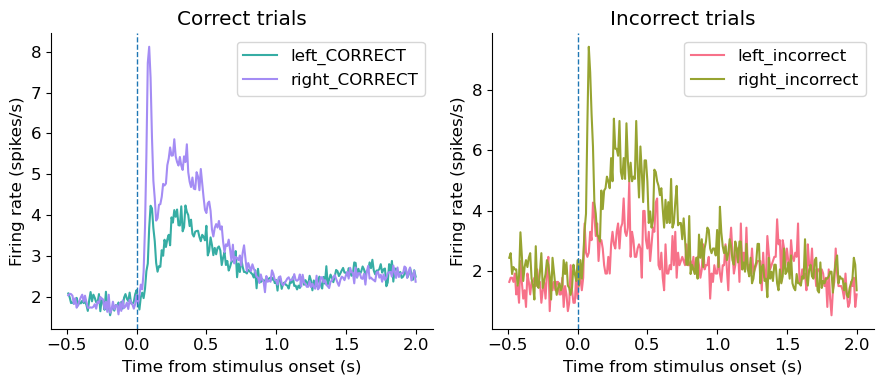

In [45]:
# Plot PSTHs grouped by trial types
# dont forget to label axes!

def psth_for_type(tt_idx):
    mask = (trial_types == tt_idx)
    spks_this_type = spks[:, mask, :]
    mean_over_trials = spks_this_type.mean(axis=1)
    mean_over_neurons = mean_over_trials.mean(axis=0)
    psth_hz = mean_over_neurons / dt
    return psth_hz


fig, axes = plt.subplots(1, 2, figsize=[9, 4])

ax = axes[0]
ax.plot(timevec, psth_for_type(3), color=tt_col[2])
ax.plot(timevec, psth_for_type(4), color=tt_col[3])
ax.axvline(0, linestyle='--', linewidth=1)
ax.set_title('Correct trials')
ax.set_xlabel('Time from stimulus onset (s)')
ax.set_ylabel('Firing rate (spikes/s)')
ax.legend([tt_names[2], tt_names[3]], fontsize=12, loc='upper right')

ax = axes[1]
ax.plot(timevec, psth_for_type(1), color=tt_col[0])
ax.plot(timevec, psth_for_type(2), color=tt_col[1])
ax.axvline(0, linestyle='--', linewidth=1)
ax.set_title('Incorrect trials')
ax.set_xlabel('Time from stimulus onset (s)')
ax.set_ylabel('Firing rate (spikes/s)')
ax.legend([tt_names[0], tt_names[1]], fontsize=12, loc='upper right');



## 2e. Interpret data

**i. Why are the PSTHs in the right panel noisier than those on the left?**

**ii. In this session, do you think more neurons were recorded from the left or right hemisphere? Why?**
<br><br>

<font color=#2AAA8A><span style="font-size:larger;"> i. The PSTHs in the right panel are noisier because incorrect trials happen less often so it is averaged over fewer trials. With fewer trials the mean estimate has higher variance from bin to bin so the curve looks noisier.

<font color=#2AAA8A><span style="font-size:larger;"> ii. I think more neurons were recorded from the left hemisphere. The responses are clearly stronger when the right stimulus is the higher contrast one. Because the right visual field maps to the left visual cortex, the stronger right stimulus response means more neurons were recorded from the left hemisphere.

<br><br>

---
# Background for Part C

In Section C, we'll be using PCA to better understand the population's responses. There are many ways to use PCA to do this. The PCA process would be the same for each, but the input data (preparation steps) would differ. This **[image](https://drive.google.com/file/d/114sv9th-OPsj69PLsqMUVb-6waHo0PWP/view?usp=sharing)** created by Pietro Marchesi illustrates a variety of common preprocssing options.

In Section C, we'll look at **time-averaged data**, meaning the firing rate/number of spikes per trial. (Called "Trial-response" in the image linked above.) With this approach, we lose any information in the temporal dynamics of the response, but we preserve sensitivity to trial-to-trial fluctuations in activity across the population. We'll first calculate PCA "manually", step by step using code, and then we'll compare the result to the output of sklearn's PCA function.
<br><br>



# Part C: Manually apply PCA on time-averaged data<br>

## 2f. Step 0: Prepare data (code)

For this analysis, we want to investigate how the number of spikes emitted by each neuron varies across individual trials of each of the four types. Therefore, to prepare the data for PCA we need to average the response over time.

In [46]:
# # Step 0: Prepare data

# First, we have to define the response window.
resp_win = timevec>0

# Then define our data matrix X. The dimensions of X should be [features x samples]
X = spks[:, :, resp_win].mean(axis=2) 

print("X shape:", X.shape)



X shape: (145, 340)


<br><br>
## 2g. Step 1: Standardize data (code)

Before beginning the PCA calculations, we want to center and scale the data so that all features (neurons, in this case) have an equal opportunity to determine latent features of the response. In other words, we want to transform the features such that the mean $≈$ 0 and the variance $≈$ 1. (This standardization is sometimes called the z-score.)

If we skipped this step, the neurons with the highest firing rates would dominate the PCA result. There are philosophical discussions to be had, but typically neuroscientists would agree that a neuron whose FR changes from 0 to 10 sp/s when a stimulus begins is more important in the representation as a neuron whose FR goes from 45 sp/s to 55 sp/s, even though both show rate increases of 10 sp/s.

In [47]:
# # Step 1: Standardize the data

X += np.random.rand(X.shape[0],X.shape[1]) *  1e-9  # add a tiny bit of noise to avoid division by zero in next step

mu = X.mean(axis=1, keepdims=True)
sd = X.std(axis=1, keepdims=True)

Xz = (X - mu) / sd


# Note: we don't want NaNs in the result!
if np.isnan(Xz).any():
  print('WARNING: result contains NaNs.')
else:
  print('Result does not contain NaNs. All good to proceed!')


Result does not contain NaNs. All good to proceed!


<br><br>
## 2h. Step 2: Compute covariance matrix (code)

Now that we have a centered/standardized data matrix, which we call $Xz$, we can compute the covariance matrix by:
<br><br>
$$
\Sigma = \frac{1}{n-1} X_z X_z^T
$$
<br>
Do this manually, using linear algebra, instead of using a built-in function.

In [48]:
# # Step 2: Compute covariance matrix

n = Xz.shape[1]
cov_mat = (1 / (n - 1)) * (Xz @ Xz.T)

# Sanity check: what shape do we expect the covariance matrix to be?
# It represents the degree to which the activity of each neuron covaries with the activity of the other neurons...
print(cov_mat.shape)

# The covariance matrix should be symmetric. Check that it is!
print("cov_mat symmetric:", np.allclose(cov_mat, cov_mat.T, atol=1e-10))


(145, 145)
cov_mat symmetric: True


<br><br>
## Step 3: Eigendecomposition of covariance matrix.


Top 5 eigenvalues: 
[17.93696008  9.562907    6.548905    4.53005498  4.09609855]

Explained variance ratio by PC: [0.123 0.066 0.045 0.031 0.028 0.022 0.021 0.019 0.017 0.017 0.016 0.016
 0.014 0.014 0.013]


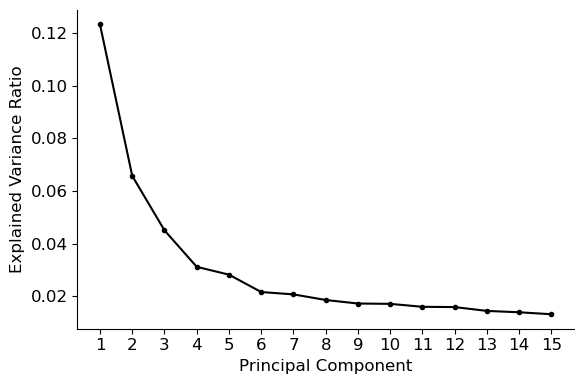

In [49]:
# Step 3: Eigendecomposition

eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

# Sort eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

print('\nTop 5 eigenvalues: \n{}\n'.format(eigenvalues[0:5,]))


# Scree plot

total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
explained_variance_ratio = explained_variance_ratio[:15]
print('Explained variance ratio by PC:', np.array2string(explained_variance_ratio, precision=3))

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, '.-k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.show()

## 2i. Interpret

**What information does the scree plot provide? What can you infer about these data?**

<font color=#2AAA8A><span style="font-size:larger;"> **The scree plot shows the explained variance ratio for each principal component is captured by individual PCs. It’s used to judge how many PCs are worth keeping by looking for an “elbow” where added PCs give diminishing returns. From these data, PC1 explains about 12% and PC2 and PC3 explain progressively less, and then the curve quickly flattens. That suggests there is some shared structure in the neural responses, a few dominant modes, but the activity is not strongly low dimensional because a lot of the variance is spread across many PCs rather than being captured by just few components.**

<br><br>
## 2j. Step 4: Project data into PC space (code)

We now have a new orthonormal basis for our high dimensional data. The eigenvectors that correspond to the top PCs represent axes that capture the most variance in the data.

Let's view our neural responses in a vector space defined by the first 2 PCs.


In [50]:
# Step 4: Project data into a new vector space, C, composed of the top 2 eigenvectors

# C = eigenvectors[:,:2]  as requested but we also want to compare with plots in part D hence 3 # define new orthonormal basis
C = eigenvectors[:,:3]
Xp = C.T @ Xz # project data into it


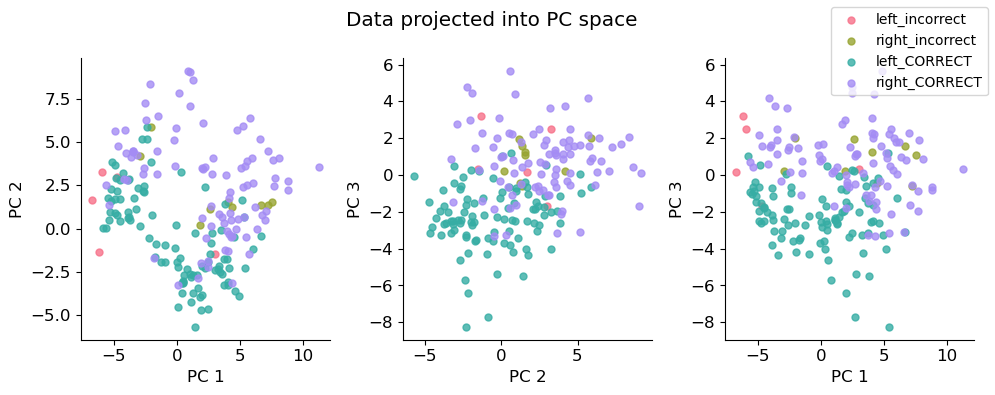

In [51]:
# Plot projected data
# projections = [(0, 1)]
projections = [(0, 1), (1, 2), (0, 2)]
fig, axes = plt.subplots(1, 3, figsize=[10, 4])
for ax, proj in zip(axes, projections):
    for t, t_type in enumerate(tt_names):
      x = Xp[proj[0], trial_types==t+1]
      y = Xp[proj[1], trial_types==t+1]
      ax.scatter(x, y, color=tt_col[t], s=25, alpha=0.8)
      ax.set_xlabel('PC {}'.format(proj[0]+1))
      ax.set_ylabel('PC {}'.format(proj[1]+1))
fig.legend(tt_names, fontsize=10, loc='outside upper right');
fig.suptitle('Data projected into PC space');

<br><br>
## 2k. Interpret result

**Based on this plot, what scientific observation(s) do you have about the dataset? Which PC (if any) has the best separation of left vs. right trials? Does the animal's behavioral response seem related to the population representation? Any other observations that you would want to follow up on, if this were your data?**

<font color=#2AAA8A><span style="font-size:larger;"> The main scientific observation is that trials separate more by stimulus side left versus right than by correctness. Right correct and right incorrect points tend to lie near each other, and left correct and left incorrect points tend to lie near each other, with some overlap across groups.

<font color=#2AAA8A><span style="font-size:larger;">PC2 shows the best separation of left versus right trials, especially in the PC1 versus PC2 projection. This means PC2 captures a major pattern of population activity that differs between left stimulus trials and right stimulus trials.

<font color=#2AAA8A><span style="font-size:larger;">The animal’s behavioral response does not appear strongly separated in these first PCs because incorrect trials mostly overlap with correct trials for the same stimulus side. This means that the largest differences in population activity here are more related to the sensory stimulus side than to whether the animal made the correct choice.


<font color=#2AAA8A><span style="font-size:larger;">If this were my data I would also summarize each condition by its average location in PC space and try a different response window to see whether the same separation holds or whether it changes depending on when I measure the response.

<br><br>

---
# Part D: Perform PCA with built-in code

Fortunately, you don't need to perform all of these steps manually each time. Instead, you can use scikit-learn's PCA class: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

In [52]:

from sklearn.decomposition import PCA

# Use same input data as above: Xz
pca = PCA(n_components=15, svd_solver='covariance_eigh')
X_proj = pca.fit_transform(Xz.T).T

# Check that dimensions match what you'd expect
print('Shape of the input data: ',Xz.shape)
print('Shape of the projected data: ',X_proj.shape)


Shape of the input data:  (145, 340)
Shape of the projected data:  (15, 340)



Explained variance ratio, manual: [0.123 0.066 0.045 0.031 0.028 0.022 0.021 0.019 0.017 0.017 0.016 0.016
 0.014 0.014 0.013]

Explained variance ratio, sklearn: [0.123 0.066 0.045 0.031 0.028 0.022 0.021 0.019 0.017 0.017 0.016 0.016
 0.014 0.014 0.013]




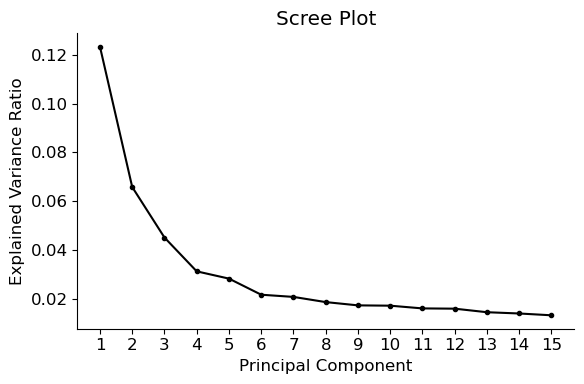

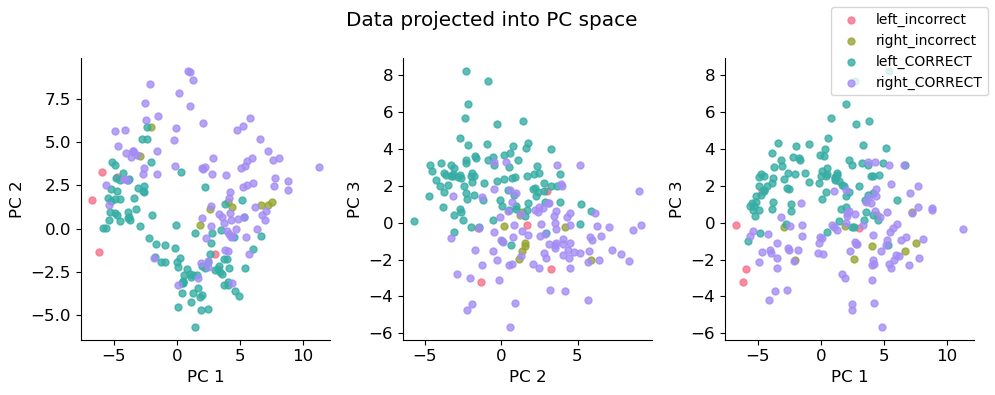

In [53]:
# Inspect results
print('\nExplained variance ratio, manual:', np.array2string(explained_variance_ratio, precision=3))
print('\nExplained variance ratio, sklearn:', np.array2string(pca.explained_variance_ratio_, precision=3))
print('\n')

# Scree plot (uncomment to show)
plt.figure(figsize=(6, 4))  # Smaller plot size
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, '.-k')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))  # Integer x-axis ticks
plt.show()
print('\n\n')

# Plot projected data
projections = [(0, 1), (1, 2), (0, 2)]
fig, axes = plt.subplots(1, 3, figsize=[10, 4])
for ax, proj in zip(axes, projections):
    for t, t_type in enumerate(tt_names):
      x = X_proj[proj[0], trial_types==t+1]
      y = X_proj[proj[1], trial_types==t+1]
      ax.scatter(x, y, color=tt_col[t], s=25, alpha=0.8)
      ax.set_xlabel('PC {}'.format(proj[0]+1))
      ax.set_ylabel('PC {}'.format(proj[1]+1))
fig.legend(tt_names, fontsize=10, loc='outside upper right');
fig.suptitle('Data projected into PC space');

## 2l. Compare the results

**Are the results the same? How/what did you inspect to determine if they are or not?**
<br>

<font color=#2AAA8A><span style="font-size:larger;"> **The results are the same in terms of what PCA found, even though the scatter plots do not look exactly identical. I inspected the explained variance ratios and they match exactly between the manual PCA and sklearn, which means the same amount of variance is captured by each PC. I also compared the PC scatter plots and saw that the overall clustering pattern is the same, but some axes are flipped. This happens because PCA components can differ by a sign change**

<br><br>
---

# Optional challenges


**Was this exercise relatively easy for you? Choose a challenge below to tackle.**

* Demonstrate why the spiking data should be standardized in order to obtain a reliable result.
* In the population averaged PSTHs, there's a peak around 50 ms and a slower response spread around 300 ms. Is there evidence that these responses result from distinct populations of cells? Explain the logic and approach of how you could address this question and infer an answer. If you want to go further, execute the plan and describe what you find!


<br><br><br>
Credits: Data from Steinmetz et al, 2019 ([paper](https://www.nature.com/articles/s41586-019-1787-x); [data](https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406)). Image from [Pietro Marchesi's tutorial](https://pietromarchesi.net/pca-neural-data.html).
